In [1]:
import backtrader as bt
import yfinance as yf
import pyfolio as pf
import pandas as pd

/opt/anaconda3/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
class MACDStrategy(bt.Strategy):

    # In the initial method, we set up the initializations needed for the strategy
    def __init__(self):
        # Initialize MACD indicator using closing price
        self.macd = bt.indicators.MACD(self.data.close)
        
        # Initialize variable for tracking open orders
        self.order = None

    # This method executes for each new day/data point in the provided dataset
    def next(self):

        # Check if we have an open order, if we do then skip one cycle (we don't want to create a new order while current one is executing)
        if self.order:
            return

        # Check conditions for buying:
        # 1) If there is no open position
        # 2) If current MACD value is greater than Signal line
        if not self.position and self.macd.macd[0] > self.macd.signal[0]:
            # Calculate how many shares we can buy with current available amount
            cash = self.broker.get_cash()
            price = self.data.close[0]
            shares_to_buy = cash // price

            # If we can buy at least one share, create buy order
            if shares_to_buy > 0:
                self.log('Kreiraj kupnju, %.2f' % price)
                self.order = self.buy(size=shares_to_buy)

        # Check conditions for selling:
        # 1) If there is an open position
        # 2) If current MACD value is less than Signal line
        elif self.position and self.macd.macd[0] < self.macd.signal[0]:
            self.log('Kreiraj prodaju, %.2f' % self.data.close[0])
            self.order = self.sell(size=self.position.size)

    # This method is used for printing messages to console
    def log(self, txt):
        dt = self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    # This method tracks order status and prints logs depending on order status
    def notify_order(self, order):
        if order.status == order.Completed:
            if order.isbuy():
                self.log(
                "Izvršena KUPNJA (Cijena: %.2f, Vrijednost: %.2f)" %
                (order.executed.price, order.executed.value))
            else:
                self.log(
                "Izvršena PRODAJA (Cijena: %.2f, Vrijednost: %.2f)" %
                (order.executed.price, order.executed.value))
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Narudžba je otkazana/margina/odbijena")
        self.order = None

In [3]:
def test_strategy(strategy_class, ticker, start_date, end_date, starting_cash=100000):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class)
    
    # Download data and store it in a variable
    yf_data = yf.download(ticker, start=start_date, end=end_date)
    data = bt.feeds.PandasData(dataname=yf_data)
    cerebro.adddata(data)
    
    cerebro.broker.setcash(starting_cash)
    cerebro.broker.setcommission(commission=0.0002)
    
    # Add observer for tracking portfolio value
    cerebro.addobserver(bt.observers.Value)
    
    # Add analyzer for tracking returns
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    
    print('Početno stanje portfelja: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    print('Završno stanje portfelja: %.2f' % cerebro.broker.getvalue())
    
    strat = results[0]
    
    # Get data from PyFolio analyzer
    portfolio_value = strat.analyzers.pyfolio.get_pf_items()
    returns, positions, transactions, gross_lev = portfolio_value

    # Get portfolio values
    portfolio_values = strat.observers.value.get(size=len(strat))
    
    # Create DataFrame with dates and portfolio values
    df_portfolio = pd.DataFrame({
        'Date': yf_data.index,
        'Value': portfolio_values
    })    
    
    # Use pyfolio to generate report
    pf.create_simple_tear_sheet(returns)

    return df_portfolio

[*********************100%%**********************]  1 of 1 completed

Početno stanje portfelja: 100000.00
2024-03-14, Kreiraj kupnju, 425.22
2024-03-15, Izvršena KUPNJA (Cijena: 419.29, Vrijednost: 98533.15)
2024-03-28, Kreiraj prodaju, 420.72
2024-04-01, Izvršena PRODAJA (Cijena: 423.95, Vrijednost: 98533.15)
2024-05-06, Kreiraj kupnju, 413.54
2024-05-07, Narudžba je otkazana/margina/odbijena
2024-05-07, Kreiraj kupnju, 409.34
2024-05-08, Izvršena KUPNJA (Cijena: 408.17, Vrijednost: 100409.82)
2024-05-31, Kreiraj prodaju, 415.13
2024-06-03, Izvršena PRODAJA (Cijena: 415.53, Vrijednost: 100409.82)
2024-06-11, Kreiraj kupnju, 432.68
2024-06-12, Narudžba je otkazana/margina/odbijena
2024-06-12, Kreiraj kupnju, 441.06
2024-06-13, Izvršena KUPNJA (Cijena: 440.85, Vrijednost: 102718.05)
2024-07-11, Kreiraj prodaju, 454.70
2024-07-12, Izvršena PRODAJA (Cijena: 454.33, Vrijednost: 102718.05)
Završno stanje portfelja: 105924.62



/opt/anaconda3/lib/python3.11/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.521%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2024-01-02
End date,2024-07-30
Total months,6
,Backtest
Annual return,10.521%
Cumulative returns,5.925%
Annual volatility,9.123%
Sharpe ratio,1.14
Calmar ratio,2.87
Stability,0.76
Max drawdown,-3.66%


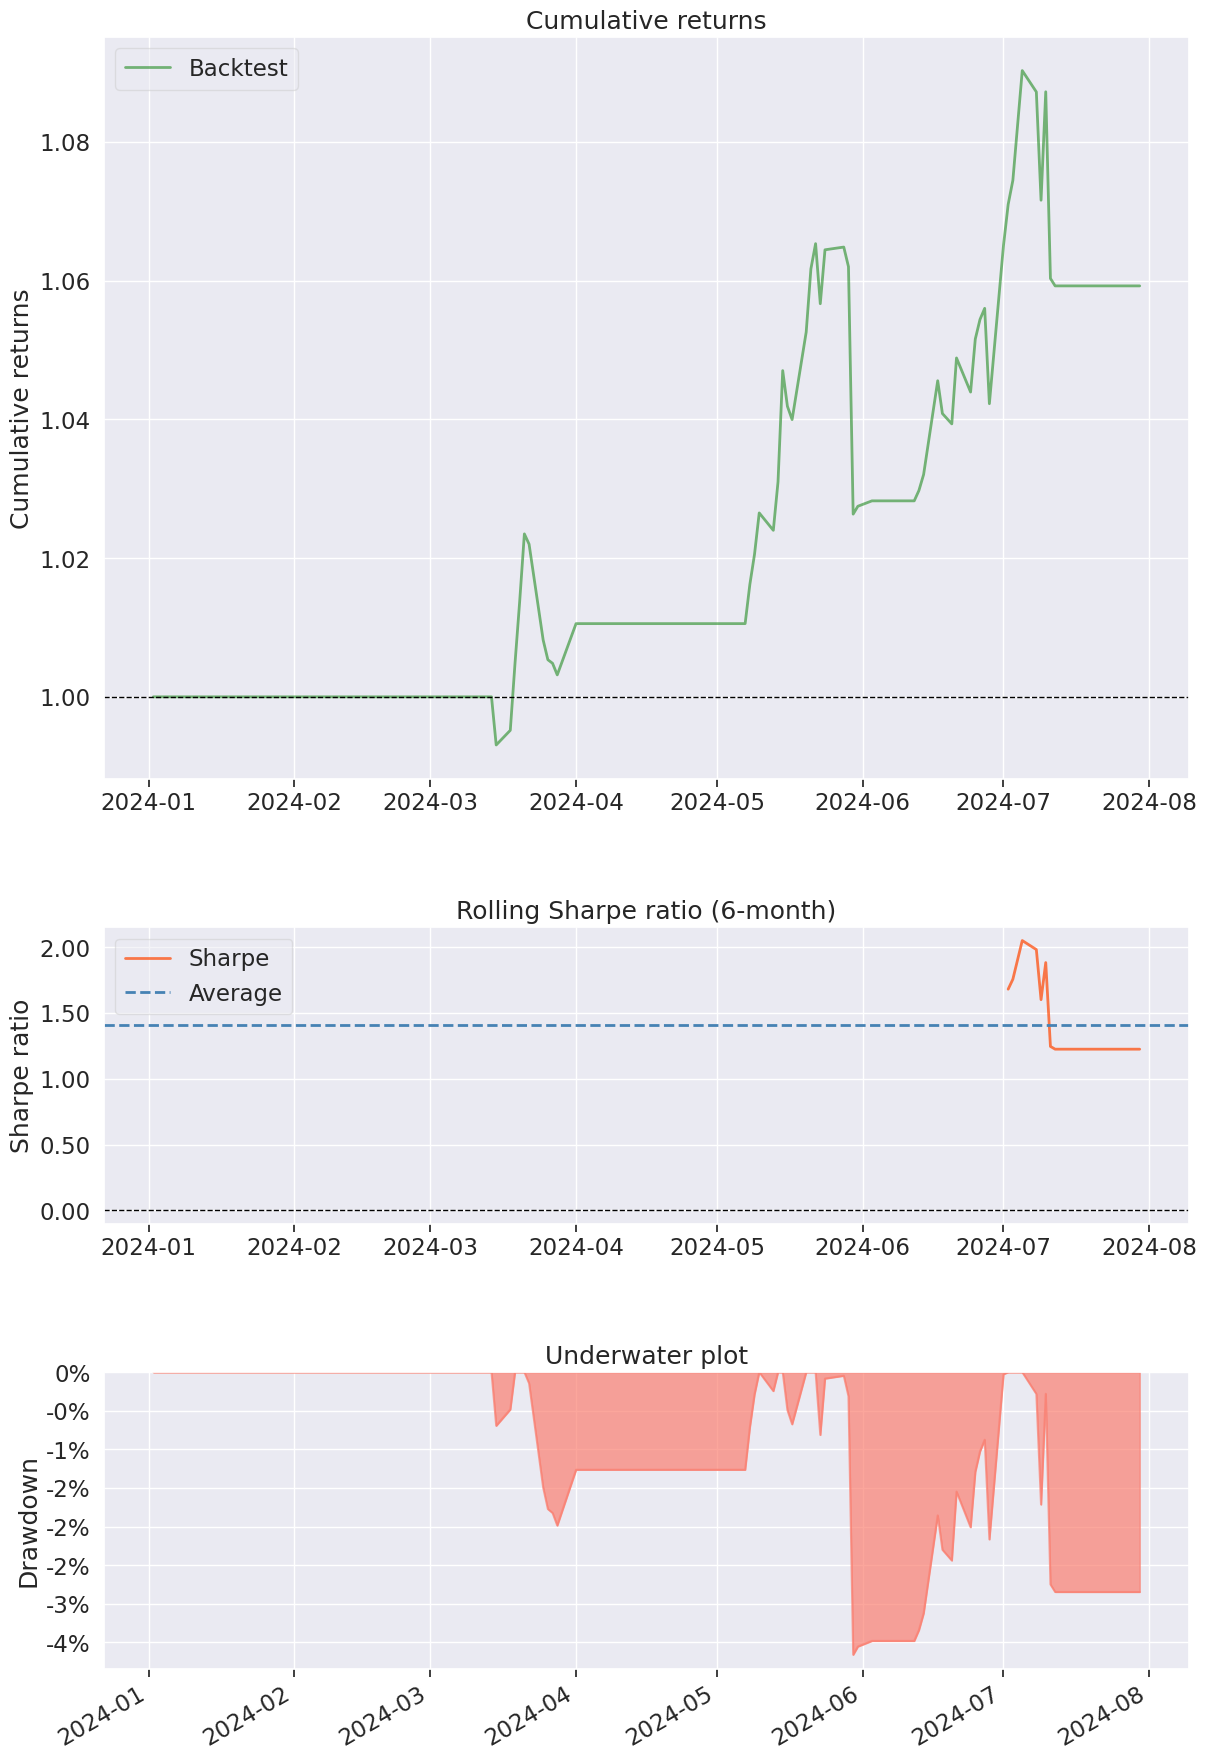

In [4]:
results = test_strategy(MACDStrategy, 'MSFT', '2024-01-01', '2024-07-31')

In [5]:
import pickle

# Za df_account_value_sac
with open('msft_macd_strategy.pkl', 'wb') as f:
    pickle.dump(results, f)